## CIFAR 10

In [1]:
###code starts here
import sys
import os
os.getcwd()
sys.path.insert(0,"/notebooks") ###link the fast AI package

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [3]:
from fastai.conv_learner import *
import torch
import shutil
PATH = "/notebooks/courses/dl1/data/cifar/"
OUTPATH = "/notebooks/courses/dl1/data/cifar10/"
os.makedirs(PATH,exist_ok=True)
shutil.rmtree(OUTPATH, ignore_errors=True)
os.makedirs(OUTPATH,exist_ok=True)

In [4]:
!ls /notebooks/courses/dl1/data/cifar/

labels.txt  test  train


In [5]:

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [6]:
for x in classes:
    os.makedirs(OUTPATH+'train/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'val/'+x,exist_ok=True) 
    os.makedirs(OUTPATH+'test/'+x,exist_ok=True) 

In [7]:
filenames = os.listdir(PATH+'train/')
counts = {x:0 for x in classes}
print(len(filenames))

50000


In [8]:
!ls /notebooks/courses/dl1/data/cifar10/train

bird  car  cat	deer  dog  frog  horse	plane  ship  truck


In [ ]:
valset_size = len(filenames) / 10 * .2
for file_n in filenames:
    for x in classes:
        if x in file_n:
            counts[x] = counts[x] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/'+x+'/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/'+x+'/'+file_n)
        if 'automobile' in file_n:
            counts['car'] = counts['car'] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/car/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/car/'+file_n)

In [ ]:
!ls /notebooks/courses/dl1/data/cifar10/train

In [ ]:
!ls /notebooks/courses/dl1/data/cifar10/val

In [ ]:
!ls /notebooks/courses/dl1/data/cifar/test

In [ ]:
filenames = os.listdir(PATH+'test/')
for file_n in filenames:
    shutil.copy(PATH+'test/'+file_n, OUTPATH+'test/'+file_n)

In [ ]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(OUTPATH, val_name='val', tfms=tfms, bs=bs)

### Look at data

In [ ]:
data = get_data(32,4)

In [ ]:
x,y=next(iter(data.trn_dl))

In [ ]:
plt.imshow(data.trn_ds.denorm(x)[0]);

In [ ]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [ ]:
bs=256
data = get_data(32,bs)

In [ ]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [178]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [181]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [182]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [183]:
learn.lr_find()

 75%|███████▌  | 120/160 [00:13<00:04,  8.93it/s, loss=14.3]

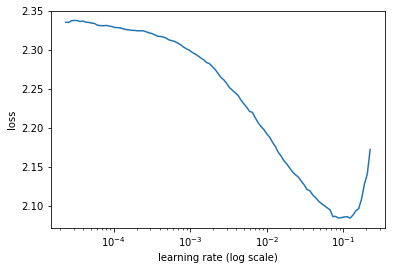

In [184]:
learn.sched.plot()

In [185]:
%time learn.fit(lr, 2)

  7%|▋         | 11/160 [00:01<00:25,  5.83it/s, loss=2.16] 


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.803021   1.683625   0.399538  
    1      1.700869   1.593857   0.437996                   

CPU times: user 41 s, sys: 32.7 s, total: 1min 13s
Wall time: 42 s


[array([1.59386]), 0.43799578284975493]

In [186]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.631089   1.548501   0.447535  
    1      1.615734   1.526549   0.459584                   

CPU times: user 41.5 s, sys: 32.5 s, total: 1min 14s
Wall time: 41.9 s


[array([1.52655]), 0.4595842957317093]

## CNN

In [198]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [199]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [200]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [201]:
learn.lr_find(end_lr=100)

 73%|███████▎  | 117/160 [00:13<00:04,  8.78it/s, loss=308] 

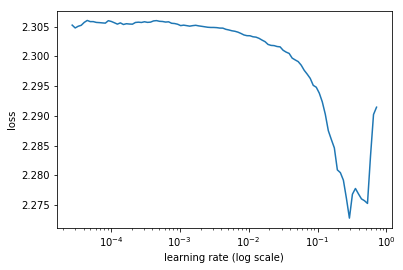

In [202]:
learn.sched.plot()

In [203]:
%time learn.fit(1e-1, 2)

 46%|████▌     | 73/160 [00:08<00:10,  8.22it/s, loss=2.02]

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.746552   1.609193   0.40737   
    1      1.544      1.459366   0.474445                   

CPU times: user 42.1 s, sys: 34 s, total: 1min 16s
Wall time: 43.7 s


[array([1.45937]), 0.4744452256756095]

In [204]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.380489   1.31926    0.533286  
    1      1.313077   1.250541   0.556682                   
    2      1.267643   1.203501   0.569334                   
    3      1.229829   1.172473   0.585199                   

CPU times: user 1min 23s, sys: 1min 7s, total: 2min 31s
Wall time: 1min 27s


[array([1.17247]), 0.5851993169491521]

## Refactored

In [207]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [208]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [209]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [210]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [211]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.779631   1.656828   0.403755  
    1      1.55241    1.49043    0.469927                   

CPU times: user 41.1 s, sys: 34.4 s, total: 1min 15s
Wall time: 43.4 s


[array([1.49043]), 0.469926699431908]

In [212]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.435353   1.334218   0.524551  
    1      1.337783   1.259333   0.554875                   

CPU times: user 42.1 s, sys: 34.1 s, total: 1min 16s
Wall time: 44 s


[array([1.25933]), 0.5548749878674892]

## BatchNorm

In [213]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [214]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [215]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [216]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [217]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.535814   1.358063   0.498042  
    1      1.331295   1.227673   0.564715                   

CPU times: user 44.7 s, sys: 36.2 s, total: 1min 20s
Wall time: 47.6 s


[array([1.22767]), 0.5647153334572608]

In [218]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.228121   1.067694   0.621448  
    1      1.113474   0.991042   0.647555                   
    2      1.034212   0.926704   0.669445                   
    3      0.977322   0.901841   0.683101                    

CPU times: user 1min 30s, sys: 1min 11s, total: 2min 42s
Wall time: 1min 34s


[array([0.90184]), 0.6831007130785943]

## Deep BatchNorm

In [47]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [48]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [49]:
%time learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       1.53499  1.43782  0.47588]                       
[ 1.       1.28867  1.22616  0.55537]                       

CPU times: user 1min 22s, sys: 34.5 s, total: 1min 56s
Wall time: 58.2 s


In [50]:
%time learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.10933  1.06439  0.61582]                       
[ 1.       1.04663  0.98608  0.64609]                       

CPU times: user 1min 21s, sys: 32.9 s, total: 1min 54s
Wall time: 57.6 s


## Resnet

In [53]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [54]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [55]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [56]:
wd=1e-5

In [57]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

[ 0.       1.58191  1.40258  0.49131]                       
[ 1.       1.33134  1.21739  0.55625]                       

CPU times: user 1min 27s, sys: 34.3 s, total: 2min 1s
Wall time: 1min 3s


In [58]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

[ 0.       1.11534  1.05117  0.62549]                       
[ 1.       1.06272  0.97874  0.65185]                       
[ 2.       0.92913  0.90472  0.68154]                        
[ 3.       0.97932  0.94404  0.67227]                        
[ 4.       0.88057  0.84372  0.70654]                        
[ 5.       0.77817  0.77815  0.73018]                        
[ 6.       0.73235  0.76302  0.73633]                        

CPU times: user 5min 2s, sys: 1min 59s, total: 7min 1s
Wall time: 3min 39s


In [59]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

[ 0.       0.8307   0.83635  0.7126 ]                        
[ 1.       0.74295  0.73682  0.74189]                        
[ 2.       0.66492  0.69554  0.75996]                        
[ 3.       0.62392  0.67166  0.7625 ]                        
[ 4.       0.73479  0.80425  0.72861]                        
[ 5.       0.65423  0.68876  0.76318]                        
[ 6.       0.58608  0.64105  0.77783]                        
[ 7.       0.55738  0.62641  0.78721]                        
[ 8.       0.66163  0.74154  0.7501 ]                        
[ 9.       0.59444  0.64253  0.78106]                        
[ 10.        0.53      0.61772   0.79385]                    
[ 11.        0.49747   0.65968   0.77832]                    
[ 12.        0.59463   0.67915   0.77422]                    
[ 13.        0.55023   0.65815   0.78106]                    
[ 14.        0.48959   0.59035   0.80273]                    
[ 15.        0.4459    0.61823   0.79336]                    
[ 16.   

## Resnet 2

In [63]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [70]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [71]:
wd=1e-6

In [72]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

[ 0.       1.7051   1.53364  0.46885]                       
[ 1.       1.47858  1.34297  0.52734]                       

CPU times: user 1min 29s, sys: 35.4 s, total: 2min 4s
Wall time: 1min 6s


In [73]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

[ 0.       1.29414  1.26694  0.57041]                       
[ 1.       1.21206  1.06634  0.62373]                       
[ 2.       1.05583  1.0129   0.64258]                       
[ 3.       1.09763  1.11568  0.61318]                       
[ 4.       0.97597  0.93726  0.67266]                        
[ 5.       0.86295  0.82655  0.71426]                        
[ 6.       0.827    0.8655   0.70244]                        

CPU times: user 5min 11s, sys: 1min 58s, total: 7min 9s
Wall time: 3min 48s


In [74]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

[ 0.       0.92043  0.93876  0.67685]                        
[ 1.       0.8359   0.81156  0.72168]                        
[ 2.       0.73084  0.72091  0.74463]                        
[ 3.       0.68688  0.71326  0.74824]                        
[ 4.       0.81046  0.79485  0.72354]                        
[ 5.       0.72155  0.68833  0.76006]                        
[ 6.       0.63801  0.68419  0.76855]                        
[ 7.       0.59678  0.64972  0.77363]                        
[ 8.       0.71126  0.78098  0.73828]                        
[ 9.       0.63549  0.65685  0.7708 ]                        
[ 10.        0.56837   0.63656   0.78057]                    
[ 11.        0.52093   0.59159   0.79629]                    
[ 12.        0.66463   0.69927   0.76357]                    
[ 13.        0.58121   0.64529   0.77871]                    
[ 14.        0.52346   0.5751    0.80293]                    
[ 15.        0.47279   0.55094   0.80498]                    
[ 16.   

In [75]:
learn.save('tmp3')

In [76]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [77]:
metrics.log_loss(y,preds), accuracy(preds,y)

(0.44507397166057938, 0.84909999999999997)

### End